# Analysis of Seasonal Radio Frequency Signal Strength Variance

## Introduction
This analysis is of radios operated by a Wireless Internet Service Provider (WISP) business in Virginia, USA. The radio equipment is used by WISP to supply internet service to its subscribers is almost entirely manufactured by Ubiquiti Networks, Inc. [1] The equipment consists of a system ofradio-based stations and access points, operating in the FCC Part 15 unlicensed radio spectrum [2] in the 2.4 and 5.8 GHz frequency ranges.

Between October, 2013 and June, 2016, WISP has been capturing hourly data from each Ubiquiti unit in the network (4032 distinct units are included in the analysis). This report is a summary and analysis of the data collected over a 988 day period.

## Methods
The data for this study were collected from the Ubiquiti AirControl centralized device management program. The data were collected hourly for each device under management by the AirControl program, using the AirControl application programming interface (api) and the Python programming language [3], and stored in a MongoDB version 2.4.10 database [4].

The data were extracted from the database and processed using Python programs. The data were not significantly altered; records in which signal strength was recorded as 0.00 dBm or -96.00 dBm were discarded as these figures indicate that the radio is not active. Unavailable dewpoints, recorded as -9999.0 were also discarded.

Statistical analyses were performed and plots were produced using the R programming language [5].

## Analysis and Discussion

Of the data collected from each radio unit, we are primarily interested in the signal strength (dBm) [6] received by each unit from its corresponding access point (AP). This is a good indicator of data throughput performance and data link reliability. A plot was produced of the mean signal strength for all radios for each hour from 14:01 on October 2, 2013 to 16:01 on June 24, 2015 (all times UCT – 5), and is shown in Figure 1.

In [1]:
# Read in the hourly dates and signals
sigs <- read.csv('signals.csv', header=T, stringsAsFactors=F)

# Assign column names
names(sigs) <- c('date', 'signal')

# Convert date strings to date objects
sigs$date <- as.Date(sigs$date)

# Do the same for the hourly dates and dewpoints
dewpts <- read.csv('dewpoints.csv')
names(dewpts) <- c('date', 'dewpoint')
dewpts$date <- as.Date(dewpts$date)

R implementation note: I am using R Base Graphics in this analysis, where I would normally use ggplot2 [7]. Base graphics are used because I want to overlay the signal strength and dewpoint graphs in Firgure 2, but [*Hadley Wikham*](http://hadley.nz/), ggplot2 author, is adamant that he does not like multiple y-axes on graphs so this feature is unavailable in ggplot2.

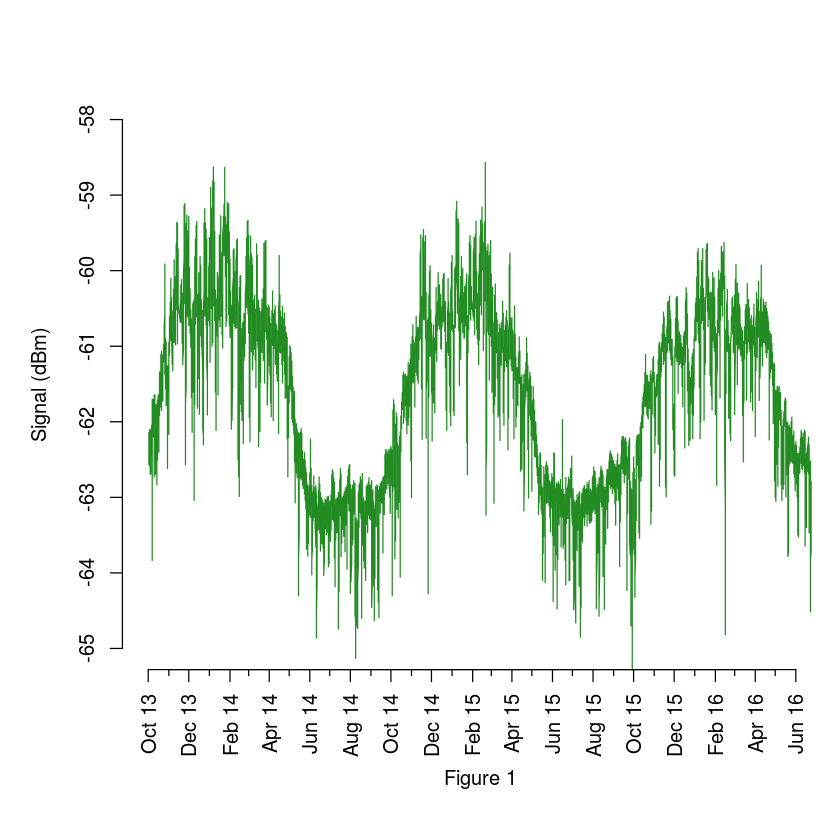

In [2]:
# Set plot margins
par(mar = c(7,5,4,0) + 0.1)

# Plot a line graph
with(sigs, plot(date, signal, type="l", col="forestgreen", 
             ylab='Signal (dBm)',
             ylim=c(-65, -58), xaxt="n",
             bty='n',
             ann=FALSE))

# Format the date tickmarks
labDates <- seq(as.Date("01/10/2013", format = "%d/%m/%Y"), tail(sigs$date, 1),
                by = "2 months")
## new dates for minor ticks

minor <- seq(as.Date("01/11/2013", format = "%d/%m/%Y"), tail(sigs$date, 1),
             by = "2 months")
axis.Date(side = 1, sigs$dates, at = labDates, format = "%b %y", las = 2)

## add minor ticks with no labels, shorter tick length
axis.Date(side = 1, sigs$date, at = minor, labels = FALSE, tcl = -0.25)

# Add y-axis label and subtitle
title(ylab = "Signal (dBm)",sub='Figure 1')

There is a distinct pattern to the variability in mean signal strength, peaking near the beginning of each year (beginning of Winter in the Northern Hemisphere), and reaching a minimum near the middle of each year (beginning of Summer in the Northern Hemisphere). An analysis of the 4032 radios that were active in the network
on both Jan 1 and July 1 of 2014, 2015, and 2016 showed that 78% experienced a median decrease in signal
strength of 3.39 dBm between February and August of each year, and 22% experienced a median increase in signal strength of 1.8 dBm over the same time period.

At microwave or higher frequencies, absorption by molecular resonance in the atmosphere (mostly water, H<sub>2</sub>O and oxygen, O<sub>2</sub> ) is a major factor in radio propagation [8]. Exploratory analysis was performed to determine any relationship between atmospheric moisture and signal strength in the WISP network. Using the application programming interface (api) from Weather Underground, hourly local weather measurements were obtained for the period October 2, 2013 to June 24, 2015 [9].

Of the available parameters available from Weather Underground, dew point was determined to bethe most interesting to explore. Dew point is a measure of specific humidity, whereas what is normally called “humidity” is relative humidity. Relative humidity is a good measure of human comfort (or discomfort), but since it is a function of both dew point and air temperature, it presents a fairly noisy signal when compared to dew point alone (it varies dramatically during the day as temperature fluctuates). Figure 2 shows a plot of hourly dew point measurements overlaid onto a the hourly signal strength plot. The dew point scale is inverted so that both signals move in the same direction on the plot.

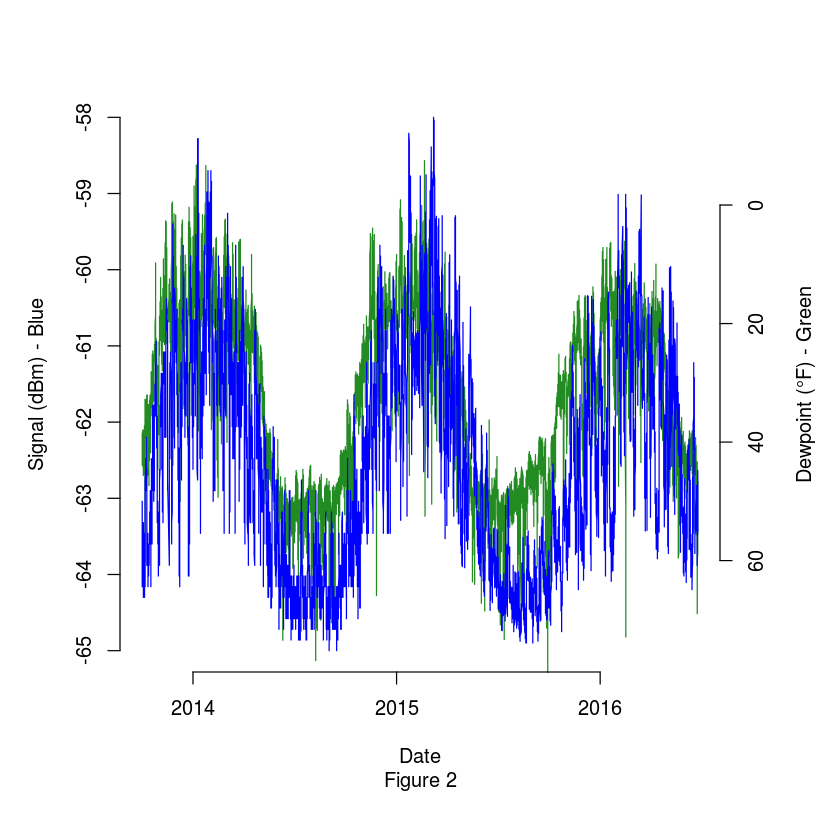

In [3]:
# Set plot margins
par(mar = c(7,5,4,5))

# Plot a line graph using the signal strength values
with(sigs, plot(date,
            signal,
            type="l",
            col="forestgreen",
            xlab='Date',
            ylab='Signal (dBm) - Blue',
            ylim=c(-65, -58),
            bty='n'))

# Overlay another graph
par(new = T)

# Plot the dewpoint line graph, this time in green
with(dewpts, plot(date,
                dewpoint,
                type="l",
                col="blue",
                axes=F,
                xlab=NA,
                ylab=NA,
                cex=1.2,
                ylim=rev(range(dewpoint))))

# Format the y-axis label for dewpoints
axis(side = 4)
mtext(side = 4, line = 3, 'Dewpoint (°F) - Green')

# Write a subtitle
title(sub='Figure 2')

### Regression Analysis

Figure 3 shows a scatterplot of signal strength vs. dew point. There is clearly a negative linear relationship between the variables. 

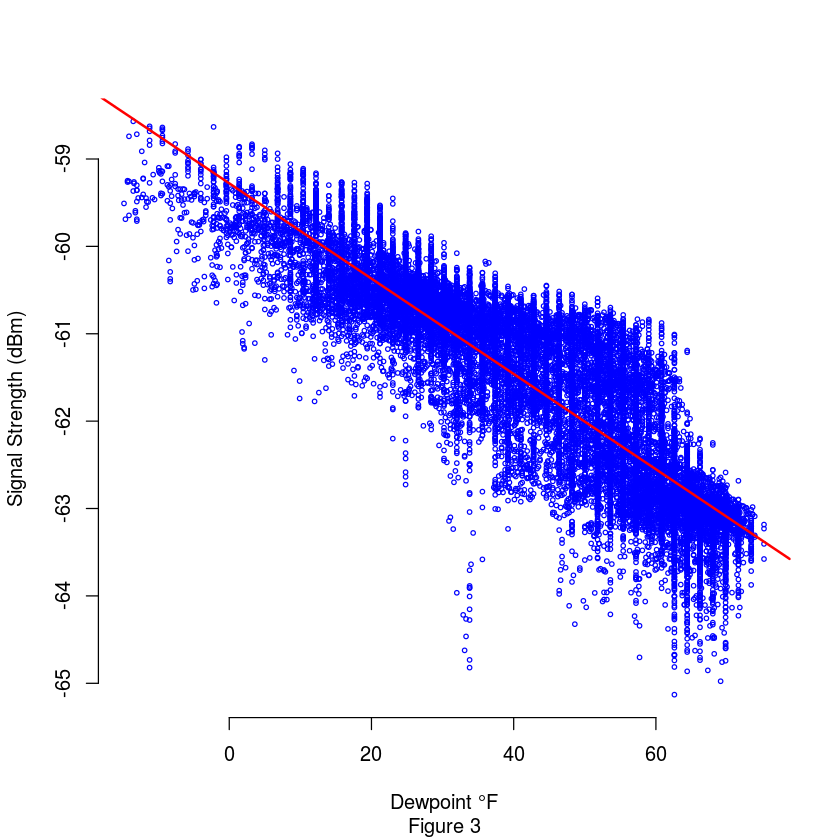

In [4]:
# Read in dewpoint & signal strength for each hour (format = dewpoint,signal_strength)
sig_dewpt <- read.csv('sig-dewpt.csv', header=T, stringsAsFactors=F)
names(sig_dewpt) <- c('dewpoint', 'signal')

# Make a scatterplot
plot(sig_dewpt$dewpoint, sig_dewpt$signal,
     xlab='Dewpoint °F',
     ylab='Signal Strength (dBm)',
     bty='n',
     cex=0.5,
     col='blue')

# Fit a linear model to the data and plot the regression line
regress <- lm(sig_dewpt$signal~sig_dewpt$dewpoint)
abline(regress, col='red',lwd=2)
title(sub="Figure 3")

Fitting a linear model to the data yields a relationship described by the equation:

`signal_strength = -59.28 - .05 * dew_point (p < .001)` 

The adjusted R-squared value of 0.77 reveals that 77% of the variation in the signal strength is attributable to variation in the dew point.

In [5]:
summary(regress)


Call:
lm(formula = sig_dewpt$signal ~ sig_dewpt$dewpoint)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.6986 -0.3311 -0.0099  0.3514  1.7179 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)        -5.928e+01  9.160e-03 -6471.7   <2e-16 ***
sig_dewpt$dewpoint -5.454e-02  1.966e-04  -277.4   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.5431 on 22046 degrees of freedom
Multiple R-squared:  0.7773,	Adjusted R-squared:  0.7773 
F-statistic: 7.696e+04 on 1 and 22046 DF,  p-value: < 2.2e-16


## Conclusions

Average hourly signal strength dropped from a high of approximately -59 dBm to a low of approximately -63 dBm between January and August of each of the three years in the study period. Between August and January, the signal strength rose back to approximately -58 dBm. This correlated strongly with dew point for the same period (adjusted R-squared = -0.77).

A possible explanation for this correlation is that the radio frequency (rf) energy is being absorbed by molecular resonance with atmospheric water. Another possibility is that dew point is serving as a proxy for some other factor, for example, tree foliage. In the geographic area where this network is operating, tree foliage begins to emerge at approximately the same time as the dew point  began to rise. However, tree foliage is observed to remain quite dense during the period when the signal strength began to increase. It may be that the moisture content of the foliage began to decline at that time. More investigation of the effects of foliage on rf propagation is needed to determine if rf propagation is affected by the moisture content of foliage. Additionally, it was shown that 78% of all radio units in the network experienced the signal strength decline. Although many radio units in the network are mounted in locations where tree foliage may affect the signal propagation, it is not clear to  the author that this is the case with 78% of the units. Clear line-of-sight is a major criteria in selecting mounting locations for the radio units, so such a high fraction of units being affected by foliage seems questionable.

## Footnotes
1. Ubiquiti Networks, Inc. http://ubnt.com
2. Title 47, Code of Federal Regulations, Part 15, Radio Frequency Devices. Federal Communications Commission: http://transition.fcc.gov/oet/info/rules/
3. G. van Rossum and F.L. Drake (eds), Python Reference Manual, PythonLabs, Virginia, USA, 2001. Available at http://www.python.org
4. MongoDB, Inc. https://www.mongodb.com
5. R Core Team. R: A Language and Environment for Statistical Computing, Vienna, Austria, 2012. URL http://www.r-project.org
6. dBm is an abbreviation for the power ratio in decibels (dB) of the measured power referenced to one milliwatt (mW). Source: https://en.wikipedia.org/wiki/DBm
7. H. Wickham. ggplot2: Elegant Graphics for Data Analysis. Springer-Verlag New York, 2009. http://ggplot2.org
8. Wikipedia.  https://en.wikipedia.org/wiki/Radio_propagation
9. Weather Underground. http://www.wunderground.com/weather/api/
